In [1]:
%matplotlib inline

import os
import pandas as pd 
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib as mpl
from matplotlib import pyplot as plt
from xgboost import plot_importance
from sklearn.metrics import roc_auc_score
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')


mpl.rc("figure", figsize=(100, 70))
mpl.rcParams.update({'font.size':25})

pd.set_option('display.max_columns', 500)

## Loading data with all features

In [2]:
merged_data = pd.read_csv("../data/train/merged_data_after_feature_engineering.csv")

## Separating the train test features

In [3]:
train = merged_data[merged_data.is_test ==0]
test = merged_data[merged_data.is_test ==1]

train['redemption_status'] =train['redemption_status'].astype('int64')
train.shape

(78369, 72)

In [4]:
columns_with_other_dtype = merged_data.select_dtypes(include=['object', 'datetime64[ns]']).columns
columns_with_numeric_dtype = merged_data.select_dtypes(exclude='object').columns
columns_with_numeric_dtype


Index(['campaign_id', 'coupon_id', 'customer_id', 'id', 'is_test',
       'redemption_status', 'campaign_type', 'customer_age_range',
       'customer_marital_status', 'is_customer_rented', 'customer_family_size',
       'customer_no_of_children', 'customer_income_bracket',
       'is_common_demographic_info_available_for_customer',
       'no_of_items_coupon_is_available_for',
       'is_coupon_available_for_multiple_item_ids',
       'no_of_categories_of_items_available_under_coupon',
       'coupon_available_on_category_1', 'coupon_available_on_category_2',
       'coupon_available_on_brand_1', 'coupon_available_on_brand_2',
       'coupon_more_focussed_on_brand_type', 'popularity_of_category1',
       'popularity_of_category2', 'popularity_of_brand1',
       'popularity_of_brand2', 'mean_discount_on_category1',
       'mean_discount_on_category2', 'mean_discount_on_brand1',
       'mean_discount_on_brand2', 'no_of_times_customer_bought_category1',
       'no_of_times_customer_bough

In [5]:
categorical_columns = columns_with_other_dtype.drop(labels=['campaign_start_date', 'campaign_end_date', 'coupon_available_on_item_ids'])
numerical_columns = columns_with_numeric_dtype.drop(labels=['coupon_id', 'customer_id', 'id'])
features = numerical_columns.append(categorical_columns)
features

Index(['campaign_id', 'is_test', 'redemption_status', 'campaign_type',
       'customer_age_range', 'customer_marital_status', 'is_customer_rented',
       'customer_family_size', 'customer_no_of_children',
       'customer_income_bracket',
       'is_common_demographic_info_available_for_customer',
       'no_of_items_coupon_is_available_for',
       'is_coupon_available_for_multiple_item_ids',
       'no_of_categories_of_items_available_under_coupon',
       'coupon_available_on_category_1', 'coupon_available_on_category_2',
       'coupon_available_on_brand_1', 'coupon_available_on_brand_2',
       'coupon_more_focussed_on_brand_type', 'popularity_of_category1',
       'popularity_of_category2', 'popularity_of_brand1',
       'popularity_of_brand2', 'mean_discount_on_category1',
       'mean_discount_on_category2', 'mean_discount_on_brand1',
       'mean_discount_on_brand2', 'no_of_times_customer_bought_category1',
       'no_of_times_customer_bought_category2',
       'no_of_times_

In [6]:
features = features.drop(labels=['is_test', 'redemption_status'])

## Generating a baseline model

In [10]:
seed = 7
test_size = 0.33

# Create XGB Classifier object
model = XGBClassifier(objective = "binary:logistic", n_estimators=1500, learning_rate=0.5,
                      max_depth=5, random_state=seed)

X = train[features].values
Y = train['redemption_status'].values


X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=test_size, random_state=seed)


# Fit model
model.fit(X_train, Y_train)

print(model)



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.5, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=1500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=7,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [11]:
roc_auc_score( Y_valid, model.predict(X_valid))

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.6008306824310706

## Defining a method for parameter comparision

In [7]:
def GridSearch_table_plot(grid_clf, param_name,
                          num_results=15,
                          negative=True,
                          graph=True,
                          display_all_params=True):

    '''Display grid search results

    Arguments
    ---------

    grid_clf           the estimator resulting from a grid search
                       for example: grid_clf = GridSearchCV( ...

    param_name         a string with the name of the parameter being tested

    num_results        an integer indicating the number of results to display
                       Default: 15

    negative           boolean: should the sign of the score be reversed?
                       scoring = 'neg_log_loss', for instance
                       Default: True

    graph              boolean: should a graph be produced?
                       non-numeric parameters (True/False, None) don't graph well
                       Default: True

    display_all_params boolean: should we print out all of the parameters, not just the ones searched for?
                       Default: True

    Usage
    -----

    GridSearch_table_plot(grid_clf, "min_samples_leaf")

                          '''

    clf = grid_clf.best_estimator_
    clf_params = grid_clf.best_params_
    if negative:
        clf_score = -grid_clf.best_score_
    else:
        clf_score = grid_clf.best_score_
    clf_stdev = grid_clf.cv_results_['std_test_score'][grid_clf.best_index_]
    cv_results = grid_clf.cv_results_

    print("best parameters: {}".format(clf_params))
    print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
    if display_all_params:
        import pprint
        pprint.pprint(clf.get_params())

    # pick out the best results
    # =========================
    scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')

    best_row = scores_df.iloc[0, :]
    if negative:
        best_mean = -best_row['mean_test_score']
    else:
        best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    best_param = best_row['param_' + param_name]

    # display the top 'num_results' results
    # =====================================
    display(pd.DataFrame(cv_results) \
            .sort_values(by='rank_test_score').head(num_results))

    # plot the results
    # ================
    scores_df = scores_df.sort_values(by='param_' + param_name)

    if negative:
        means = -scores_df['mean_test_score']
    else:
        means = scores_df['mean_test_score']
    stds = scores_df['std_test_score']
    params = scores_df['param_' + param_name]

    # plot
    if graph:
        plt.figure(figsize=(8, 8))
        plt.errorbar(params, means, yerr=stds)

        plt.axhline(y=best_mean + best_stdev, color='red')
        plt.axhline(y=best_mean - best_stdev, color='red')
        plt.plot(best_param, best_mean, 'or')

        plt.title(param_name + " vs Score\nBest Score {:0.5f}".format(clf_score))
        plt.xlabel(param_name)
        plt.ylabel('Score')
        plt.show()

## Creating a Stratified k-fold split

In [8]:
X = train[features]
Y = train['redemption_status']

skf = StratifiedKFold(n_splits=3)

In [70]:
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, auc

# define scoring function 
def custom_auc(ground_truth, predictions):
     # I need only one column of predictions["0" and "1"]. You can get an error here
     # while trying to return both columns at once
     fpr, tpr, _ = roc_curve(ground_truth, predictions[:, 1], pos_label=1)    
     return auc(fpr, tpr)
    
# to be standart sklearn's scorer        
my_auc = make_scorer(custom_auc, greater_is_better=True, needs_proba=True)

## Tuning an intuition based model

In [72]:
%%time

param_grid = {
    'n_estimators': [1500],
    'learning_rate': [0.2],
    'max_depth' : [8],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
    
}
xgb = XGBClassifier(objective='binary:logistic', nthreads= -1, seed=27, verbosity=2)

clf = GridSearchCV(xgb, param_grid=param_grid, cv=skf, n_jobs=-1, verbose=3, scoring=my_auc).fit(X, Y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=1500, subsample=0.8 
[CV] colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=1500, subsample=0.8 
[CV] colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=1500, subsample=0.8 
[CV] colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=1500, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=1500, subsample=0.8, score=0.9442963837310242, total=10.1min
[CV] colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=1500, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=1500, subsample=0.8, score=0.9547234161179452, total=10.5min


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 10.9min remaining: 16.3min


[CV]  colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=1500, subsample=0.8, score=0.956143299245552, total=10.5min
[CV]  colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=1500, subsample=0.8, score=0.9527671621039855, total=10.5min
[CV]  colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=1500, subsample=0.8, score=0.9518578230204835, total= 6.0min


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 16.6min finished


CPU times: user 7min 33s, sys: 3.95 s, total: 7min 37s
Wall time: 24min 21s


In [75]:
roc_auc_score(clf.predict(X), Y).ipynb_checkpoints/

0.9965940054495912

In [76]:
sum(clf.predict(test[features]))

95

best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 1500, 'subsample': 0.8}
best score:      0.95196 (+/-0.00411)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,521.973318,87.251714,4.909776,1.50241,0.8,0.2,8,1500,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.2...",0.952767,0.954723,0.944296,0.956143,0.951858,0.951958,0.004112,1,1.0,1.0,1.0,1.0,1.0,1.0,9.219355e-08


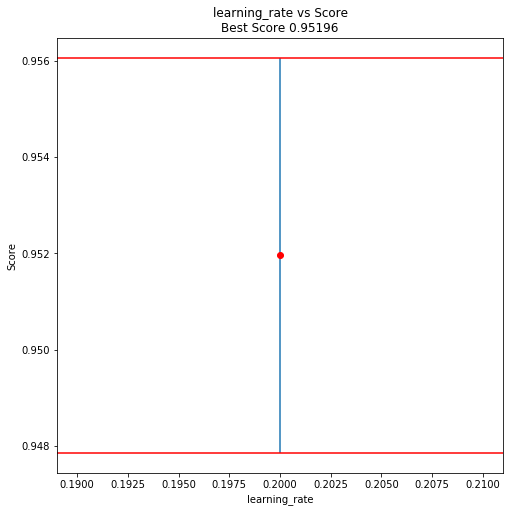

In [36]:
GridSearch_table_plot(clf, "learning_rate", display_all_params=False, negative=False)

## Tuning n_estimators and learning_rate

In [62]:
%%time

param_grid = {
    'n_estimators': [1500, 2000, 2500, 3000, 4000],
    'learning_rate': [0.2],
    'max_depth' : [8],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
    
}
xgb = XGBClassifier(objective='binary:logistic', nthreads= -1, seed=27, verbosity=2)

clf = GridSearchCV(xgb, param_grid=param_grid, cv=skf, n_jobs=-1, verbose=3, scoring='roc_auc').fit(X, Y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=1500, subsample=0.8 
[CV] colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=1500, subsample=0.8 
[CV] colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=1500, subsample=0.8 
[CV] colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=1500, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=1500, subsample=0.8, score=0.9442963837310242, total=10.3min
[CV] colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=1500, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=1500, subsample=0.8, score=0.9547234161179452, total=10.6min
[CV] colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=2000, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=1500, subsample=0.8, score=0.956143299245

[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 106.7min finished


CPU times: user 7min 41s, sys: 4.73 s, total: 7min 45s
Wall time: 1h 54min 30s


In [61]:
roc_auc_score(clf.predict(X), Y.values)

0.9965940054495912

In [58]:
sum(clf.predict(test[features]))

95

best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 1500, 'subsample': 0.8}
best score:      0.95196 (+/-0.00411)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,558.636234,7.683212,5.266151,0.657964,0.8,0.2,8,1500,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.2...",0.952767,0.954723,0.944296,0.956143,0.951858,0.951958,0.004112,1,1.0,1.0,1.0,1.0,1.0,1.0,9.219355e-08
1,779.087669,94.845417,8.419978,1.330454,0.8,0.2,8,2000,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.2...",0.951695,0.954193,0.942339,0.956054,0.949944,0.950845,0.004738,2,1.0,1.0,1.0,1.0,1.0,1.0,9.219355e-08
2,1240.339425,130.136209,15.127651,1.658172,0.8,0.2,8,2500,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.2...",0.950202,0.953585,0.939440,0.955752,0.950259,0.949848,0.005611,3,1.0,1.0,1.0,1.0,1.0,1.0,9.219355e-08
3,1586.794959,61.306332,16.326444,2.098159,0.8,0.2,8,3000,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.2...",0.949123,0.953070,0.937354,0.954173,0.948652,0.948474,0.005962,4,1.0,1.0,1.0,1.0,1.0,1.0,9.219355e-08
4,1380.685388,220.230725,13.149048,3.561868,0.8,0.2,8,4000,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.2...",0.949103,0.952820,0.935066,0.953659,0.944896,0.947109,0.006774,5,1.0,1.0,1.0,1.0,1.0,1.0,9.219355e-08


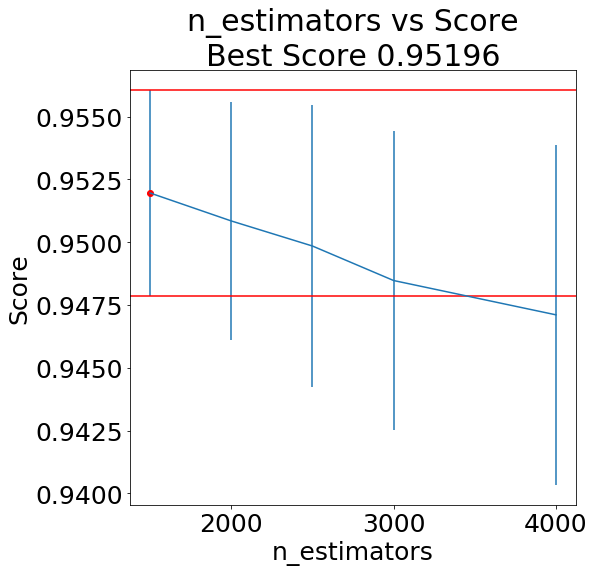

In [52]:
GridSearch_table_plot(clf, "n_estimators", display_all_params=False, negative=False)

The n_estimators need to be tuned alongwith learning_rate also there is a lot of overfitting

In [63]:
%%time

param_grid = {
    'n_estimators': [1500, 2000, 2500],
    'learning_rate': [0.2, 0.15, 0.1],
    'max_depth' : [8],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
    
}
xgb = XGBClassifier(objective='binary:logistic', nthreads= -1, seed=27, verbosity=2)

clf = GridSearchCV(xgb, param_grid=param_grid, cv=skf, n_jobs=-1, verbose=3, scoring='roc_auc').fit(X, Y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=1500, subsample=0.8 
[CV] colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=1500, subsample=0.8 
[CV] colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=1500, subsample=0.8 
[CV] colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=1500, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=1500, subsample=0.8, score=0.9442963837310242, total=10.9min
[CV] colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=1500, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=1500, subsample=0.8, score=0.9547234161179452, total=11.1min
[CV] colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=2000, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=1500, subsample=0.8, score=0.956143299245

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 96.3min


[CV]  colsample_bytree=0.8, learning_rate=0.15, max_depth=8, n_estimators=2000, subsample=0.8, score=0.9539301639751994, total=13.6min
[CV] colsample_bytree=0.8, learning_rate=0.15, max_depth=8, n_estimators=2500, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.15, max_depth=8, n_estimators=2500, subsample=0.8, score=0.9522753417600021, total=16.9min
[CV] colsample_bytree=0.8, learning_rate=0.15, max_depth=8, n_estimators=2500, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.15, max_depth=8, n_estimators=2500, subsample=0.8, score=0.9513869774794803, total=16.8min
[CV] colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=1500, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.15, max_depth=8, n_estimators=2500, subsample=0.8, score=0.940362262073638, total=17.0min
[CV] colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=1500, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.15, max_depth=8, n_estimators=2500, subsamp

[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 178.8min finished


CPU times: user 7min 55s, sys: 4.24 s, total: 7min 59s
Wall time: 3h 6min 40s


In [64]:
roc_auc_score(clf.predict(X), Y.values)

0.9979323253547724

In [65]:
sum(clf.predict(test[features]))

73

best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 1500, 'subsample': 0.8}
best score:      0.95608 (+/-0.00599)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
6,654.079521,32.476460,6.540653,0.326823,0.8,0.1,8,1500,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.954763,0.958703,0.945731,0.963955,0.957263,0.956083,0.005986,1,1.0,1.0,1.0,1.0,1.0,1.0,9.219355e-08
7,873.811878,21.027547,11.252513,1.265353,0.8,0.1,8,2000,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.953405,0.957985,0.944109,0.962413,0.955883,0.954759,0.006091,2,1.0,1.0,1.0,1.0,1.0,1.0,9.219355e-08
8,921.822817,153.252507,11.096949,4.824278,0.8,0.1,8,2500,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.951290,0.957595,0.942386,0.961509,0.955201,0.953596,0.006514,3,1.0,1.0,1.0,1.0,1.0,1.0,9.219355e-08
3,643.314793,25.074147,6.321009,0.464944,0.8,0.15,8,1500,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.954568,0.953338,0.943628,0.958540,0.956017,0.953218,0.005098,4,1.0,1.0,1.0,1.0,1.0,1.0,9.219355e-08
4,818.824265,19.332675,8.351795,0.427283,0.8,0.15,8,2000,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.953468,0.952411,0.942130,0.958205,0.953930,0.952029,0.005329,5,1.0,1.0,1.0,1.0,1.0,1.0,9.219355e-08
0,637.244949,48.954857,5.330829,0.749935,0.8,0.2,8,1500,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.2...",0.952767,0.954723,0.944296,0.956143,0.951858,0.951958,0.004112,6,1.0,1.0,1.0,1.0,1.0,1.0,9.219355e-08
5,1017.218904,18.326026,11.499066,1.159012,0.8,0.15,8,2500,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.952275,0.951387,0.940362,0.957971,0.952782,0.950955,0.005774,7,1.0,1.0,1.0,1.0,1.0,1.0,9.219355e-08
1,1020.274570,397.637454,8.860659,1.328250,0.8,0.2,8,2000,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.2...",0.951695,0.954193,0.942339,0.956054,0.949944,0.950845,0.004738,8,1.0,1.0,1.0,1.0,1.0,1.0,9.219355e-08
2,1296.080747,337.302307,11.337296,1.538397,0.8,0.2,8,2500,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.2...",0.950202,0.953585,0.939440,0.955752,0.950259,0.949848,0.005611,9,1.0,1.0,1.0,1.0,1.0,1.0,9.219355e-08


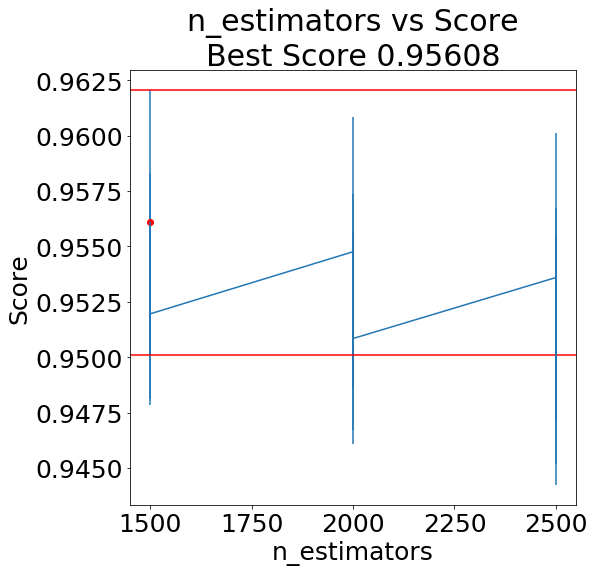

In [66]:
GridSearch_table_plot(clf, "n_estimators", display_all_params=False, negative=False)

## Tuning n_estimators

In [87]:
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True,
                             needs_threshold=True)

In [100]:
%%time

param_grid = {
    'n_estimators': [2000],
    'learning_rate': [0.3],
    'max_depth' : [8],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
    
}
xgb = XGBClassifier(objective='binary:logistic', nthreads= -1, seed=27, verbosity=2)

clf = GridSearchCV(xgb, param_grid=param_grid, cv=skf, n_jobs=-1, verbose=3, scoring=roc_auc_scorer).fit(X, Y)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] colsample_bytree=0.8, learning_rate=0.3, max_depth=8, n_estimators=2000, subsample=0.8 
[CV] colsample_bytree=0.8, learning_rate=0.3, max_depth=8, n_estimators=2000, subsample=0.8 
[CV] colsample_bytree=0.8, learning_rate=0.3, max_depth=8, n_estimators=2000, subsample=0.8 
[CV]  colsample_bytree=0.8, learning_rate=0.3, max_depth=8, n_estimators=2000, subsample=0.8, score=0.9413573091380922, total=22.6min
[CV]  colsample_bytree=0.8, learning_rate=0.3, max_depth=8, n_estimators=2000, subsample=0.8, score=0.9426575489279423, total=23.5min
[CV]  colsample_bytree=0.8, learning_rate=0.3, max_depth=8, n_estimators=2000, subsample=0.8, score=0.9422365650899053, total=23.5min


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 24.3min finished


CPU times: user 13min 52s, sys: 3.59 s, total: 13min 55s
Wall time: 50min 5s


In [101]:
roc_auc_score(clf.predict(X), Y.values)

0.9986070539370343

In [102]:
sum(clf.predict(test[features]))

111

best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 8, 'n_estimators': 2000, 'subsample': 0.8}
best score:      0.94208 (+/-0.00054)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,1366.948339,24.20627,24.673584,1.735867,0.8,0.3,8,2000,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.3...",0.942658,0.941357,0.942237,0.942084,0.000542,1,1.0,1.0,1.0,1.0,1.218082e-07


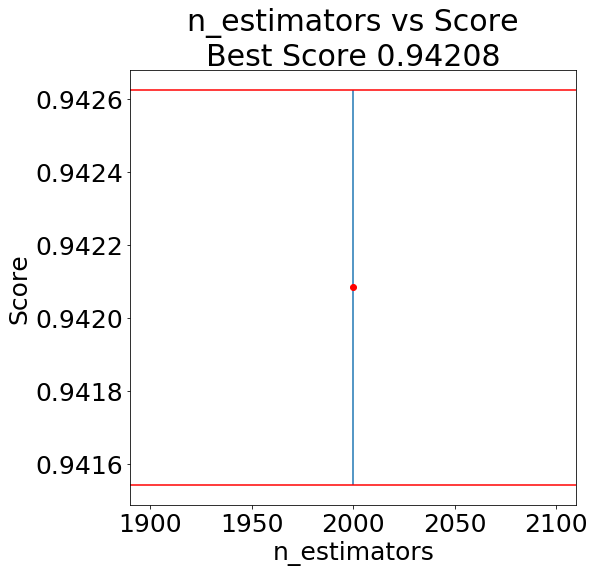

In [103]:
GridSearch_table_plot(clf, "n_estimators", display_all_params=False, negative=False)

## Tuning max_depth

In [11]:
%%time

param_grid = {
    'n_estimators': [2000],
    'learning_rate': [0.3],
    'max_depth' : [3,5,10],
    #'min_child_weight' : [0.5, 0.75, 0.9]
    #'subsample': [0.8],
    #'colsample_bytree': [0.8]
    
}
xgb = XGBClassifier(objective='binary:logistic', nthreads= -1, seed=27, verbosity=2)

clf = GridSearchCV(xgb, param_grid=param_grid, cv=skf, n_jobs=-1, verbose=3, scoring='roc_auc').fit(X, Y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] learning_rate=0.3, max_depth=3, n_estimators=2000 ...............
[CV] learning_rate=0.3, max_depth=3, n_estimators=2000 ...............
[CV] learning_rate=0.3, max_depth=3, n_estimators=2000 ...............
[CV] learning_rate=0.3, max_depth=5, n_estimators=2000 ...............
[CV]  learning_rate=0.3, max_depth=3, n_estimators=2000, score=0.9670320758677275, total=21.2min
[CV] learning_rate=0.3, max_depth=5, n_estimators=2000 ...............
[CV]  learning_rate=0.3, max_depth=3, n_estimators=2000, score=0.9669106703302993, total=21.3min
[CV] learning_rate=0.3, max_depth=5, n_estimators=2000 ...............
[CV]  learning_rate=0.3, max_depth=3, n_estimators=2000, score=0.9674442345488198, total=21.3min
[CV] learning_rate=0.3, max_depth=10, n_estimators=2000 ..............
[CV]  learning_rate=0.3, max_depth=5, n_estimators=2000, score=0.9598185833953479, total=29.0min
[CV] learning_rate=0.3, max_depth=10, n_estimators=2000 

[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed: 47.7min remaining: 23.8min


[CV]  learning_rate=0.3, max_depth=10, n_estimators=2000, score=0.957565385667309, total=29.5min
[CV]  learning_rate=0.3, max_depth=10, n_estimators=2000, score=0.959723891846509, total=32.5min
[CV]  learning_rate=0.3, max_depth=10, n_estimators=2000, score=0.9625379243230866, total=24.1min


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 71.9min finished


CPU times: user 9min 48s, sys: 3.9 s, total: 9min 52s
Wall time: 1h 33min 45s


In [12]:
roc_auc_score(clf.predict(X), Y.values)

0.9992781465894738

In [13]:
sum(clf.predict(test[features]))

154

best parameters: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 2000}
best score:      0.96713 (+/-0.00023)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,1265.962605,3.247172,9.259781,0.810412,0.3,3,2000,"{'learning_rate': 0.3, 'max_depth': 3, 'n_esti...",0.966911,0.967032,0.967444,0.967129,0.000228,1,1.0,1.0,1.0,1.0,1.218082e-07
1,1596.029844,94.108316,12.546019,1.586550,0.3,5,2000,"{'learning_rate': 0.3, 'max_depth': 5, 'n_esti...",0.959819,0.961738,0.963330,0.961629,0.001436,2,1.0,1.0,1.0,1.0,1.218082e-07
2,1704.582967,195.152938,17.702062,14.308637,0.3,10,2000,"{'learning_rate': 0.3, 'max_depth': 10, 'n_est...",0.957565,0.959724,0.962538,0.959942,0.002036,3,1.0,1.0,1.0,1.0,1.218082e-07


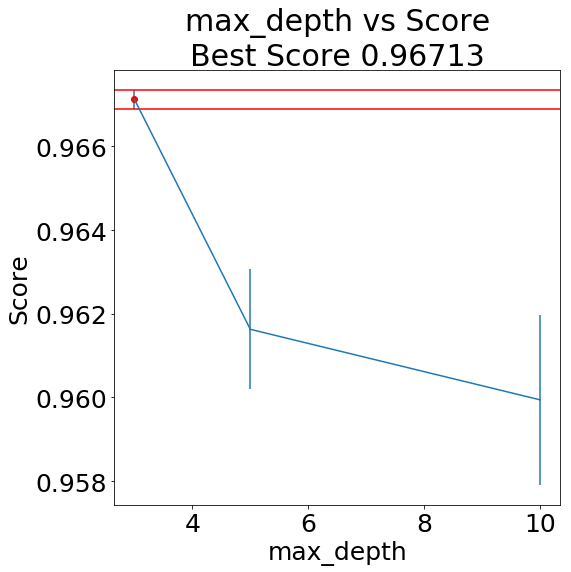

In [14]:
GridSearch_table_plot(clf, "max_depth", display_all_params=False, negative=False)

## Tuning min_child_weight

In [10]:
%%time

param_grid = {
    'n_estimators': [2000],
    'learning_rate': [0.3],
    'max_depth' : [3],
    'min_child_weight' : [0.5, 0.75, 0.9]
    
}
xgb = XGBClassifier(objective='binary:logistic', nthreads= -1, seed=27, verbosity=2)

clf = GridSearchCV(xgb, param_grid=param_grid, cv=skf, n_jobs=-1, verbose=3, scoring='roc_auc').fit(X, Y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] learning_rate=0.3, max_depth=3, min_child_weight=0.5, n_estimators=2000 
[CV] learning_rate=0.3, max_depth=3, min_child_weight=0.5, n_estimators=2000 
[CV] learning_rate=0.3, max_depth=3, min_child_weight=0.5, n_estimators=2000 
[CV] learning_rate=0.3, max_depth=3, min_child_weight=0.75, n_estimators=2000 
[CV]  learning_rate=0.3, max_depth=3, min_child_weight=0.5, n_estimators=2000, score=0.9685485717556815, total=17.5min
[CV] learning_rate=0.3, max_depth=3, min_child_weight=0.75, n_estimators=2000 
[CV]  learning_rate=0.3, max_depth=3, min_child_weight=0.75, n_estimators=2000, score=0.9661493216555039, total=17.5min
[CV] learning_rate=0.3, max_depth=3, min_child_weight=0.75, n_estimators=2000 
[CV]  learning_rate=0.3, max_depth=3, min_child_weight=0.5, n_estimators=2000, score=0.9674386691345304, total=17.5min
[CV] learning_rate=0.3, max_depth=3, min_child_weight=0.9, n_estimators=2000 
[CV]  learning_rate=0.3, max_depth

[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed: 31.6min remaining: 15.8min


[CV]  learning_rate=0.3, max_depth=3, min_child_weight=0.9, n_estimators=2000, score=0.9676705083926447, total=13.2min
[CV]  learning_rate=0.3, max_depth=3, min_child_weight=0.9, n_estimators=2000, score=0.9659193905394317, total=13.3min
[CV]  learning_rate=0.3, max_depth=3, min_child_weight=0.9, n_estimators=2000, score=0.9671709727072084, total= 6.2min


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 37.8min finished


CPU times: user 9min 32s, sys: 3.48 s, total: 9min 36s
Wall time: 54min 21s


In [14]:
roc_auc_score( Y.values,clf.predict_proba((X))[:,1])

0.9999997791502265

In [15]:
sum(clf.predict(test[features]))

119

best parameters: {'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 0.5, 'n_estimators': 2000}
best score:      0.96784 (+/-0.00050)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,1033.044009,2.616247,18.067978,0.327035,0.3,3,0.5,2000,"{'learning_rate': 0.3, 'max_depth': 3, 'min_ch...",0.967535,0.967439,0.968549,0.967841,0.000502,1,1.0,1.0,1.0,1.0,1.218082e-07
1,868.094207,114.278829,10.516132,5.582369,0.3,3,0.75,2000,"{'learning_rate': 0.3, 'max_depth': 3, 'min_ch...",0.966149,0.967625,0.968126,0.967300,0.000839,2,1.0,1.0,1.0,1.0,1.218082e-07
2,647.282320,197.255963,6.003750,2.349109,0.3,3,0.9,2000,"{'learning_rate': 0.3, 'max_depth': 3, 'min_ch...",0.965919,0.967671,0.967171,0.966920,0.000737,3,1.0,1.0,1.0,1.0,1.218082e-07


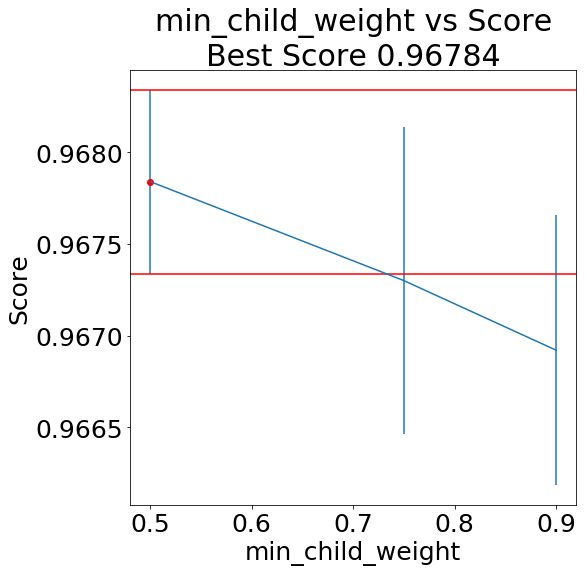

In [16]:
GridSearch_table_plot(clf, "min_child_weight", display_all_params=False, negative=False)

## Final XGB

In [11]:
%%time

param_grid = {
    'n_estimators': [2000],
    'learning_rate': [0.3],
    'max_depth' : [3],
    'min_child_weight' : [0.5]
    
}
xgb = XGBClassifier(objective='binary:logistic', nthreads= -1, seed=27, verbosity=2)

clf = GridSearchCV(xgb, param_grid=param_grid, cv=skf, n_jobs=-1, verbose=3, scoring='roc_auc').fit(X, Y)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] learning_rate=0.3, max_depth=3, min_child_weight=0.5, n_estimators=2000 
[CV] learning_rate=0.3, max_depth=3, min_child_weight=0.5, n_estimators=2000 
[CV] learning_rate=0.3, max_depth=3, min_child_weight=0.5, n_estimators=2000 
[CV]  learning_rate=0.3, max_depth=3, min_child_weight=0.5, n_estimators=2000, score=0.9675351098135745, total=23.8min
[CV]  learning_rate=0.3, max_depth=3, min_child_weight=0.5, n_estimators=2000, score=0.9685485717556815, total=23.8min
[CV]  learning_rate=0.3, max_depth=3, min_child_weight=0.5, n_estimators=2000, score=0.9674386691345304, total=23.9min


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 24.1min finished


CPU times: user 9min 27s, sys: 3.38 s, total: 9min 31s
Wall time: 39min 2s


In [12]:
roc_auc_score( Y.values,clf.predict_proba((X))[:,1])

0.9999997791502265

In [13]:
sum(clf.predict(test[features]))

119

## Plotting Feature Importances

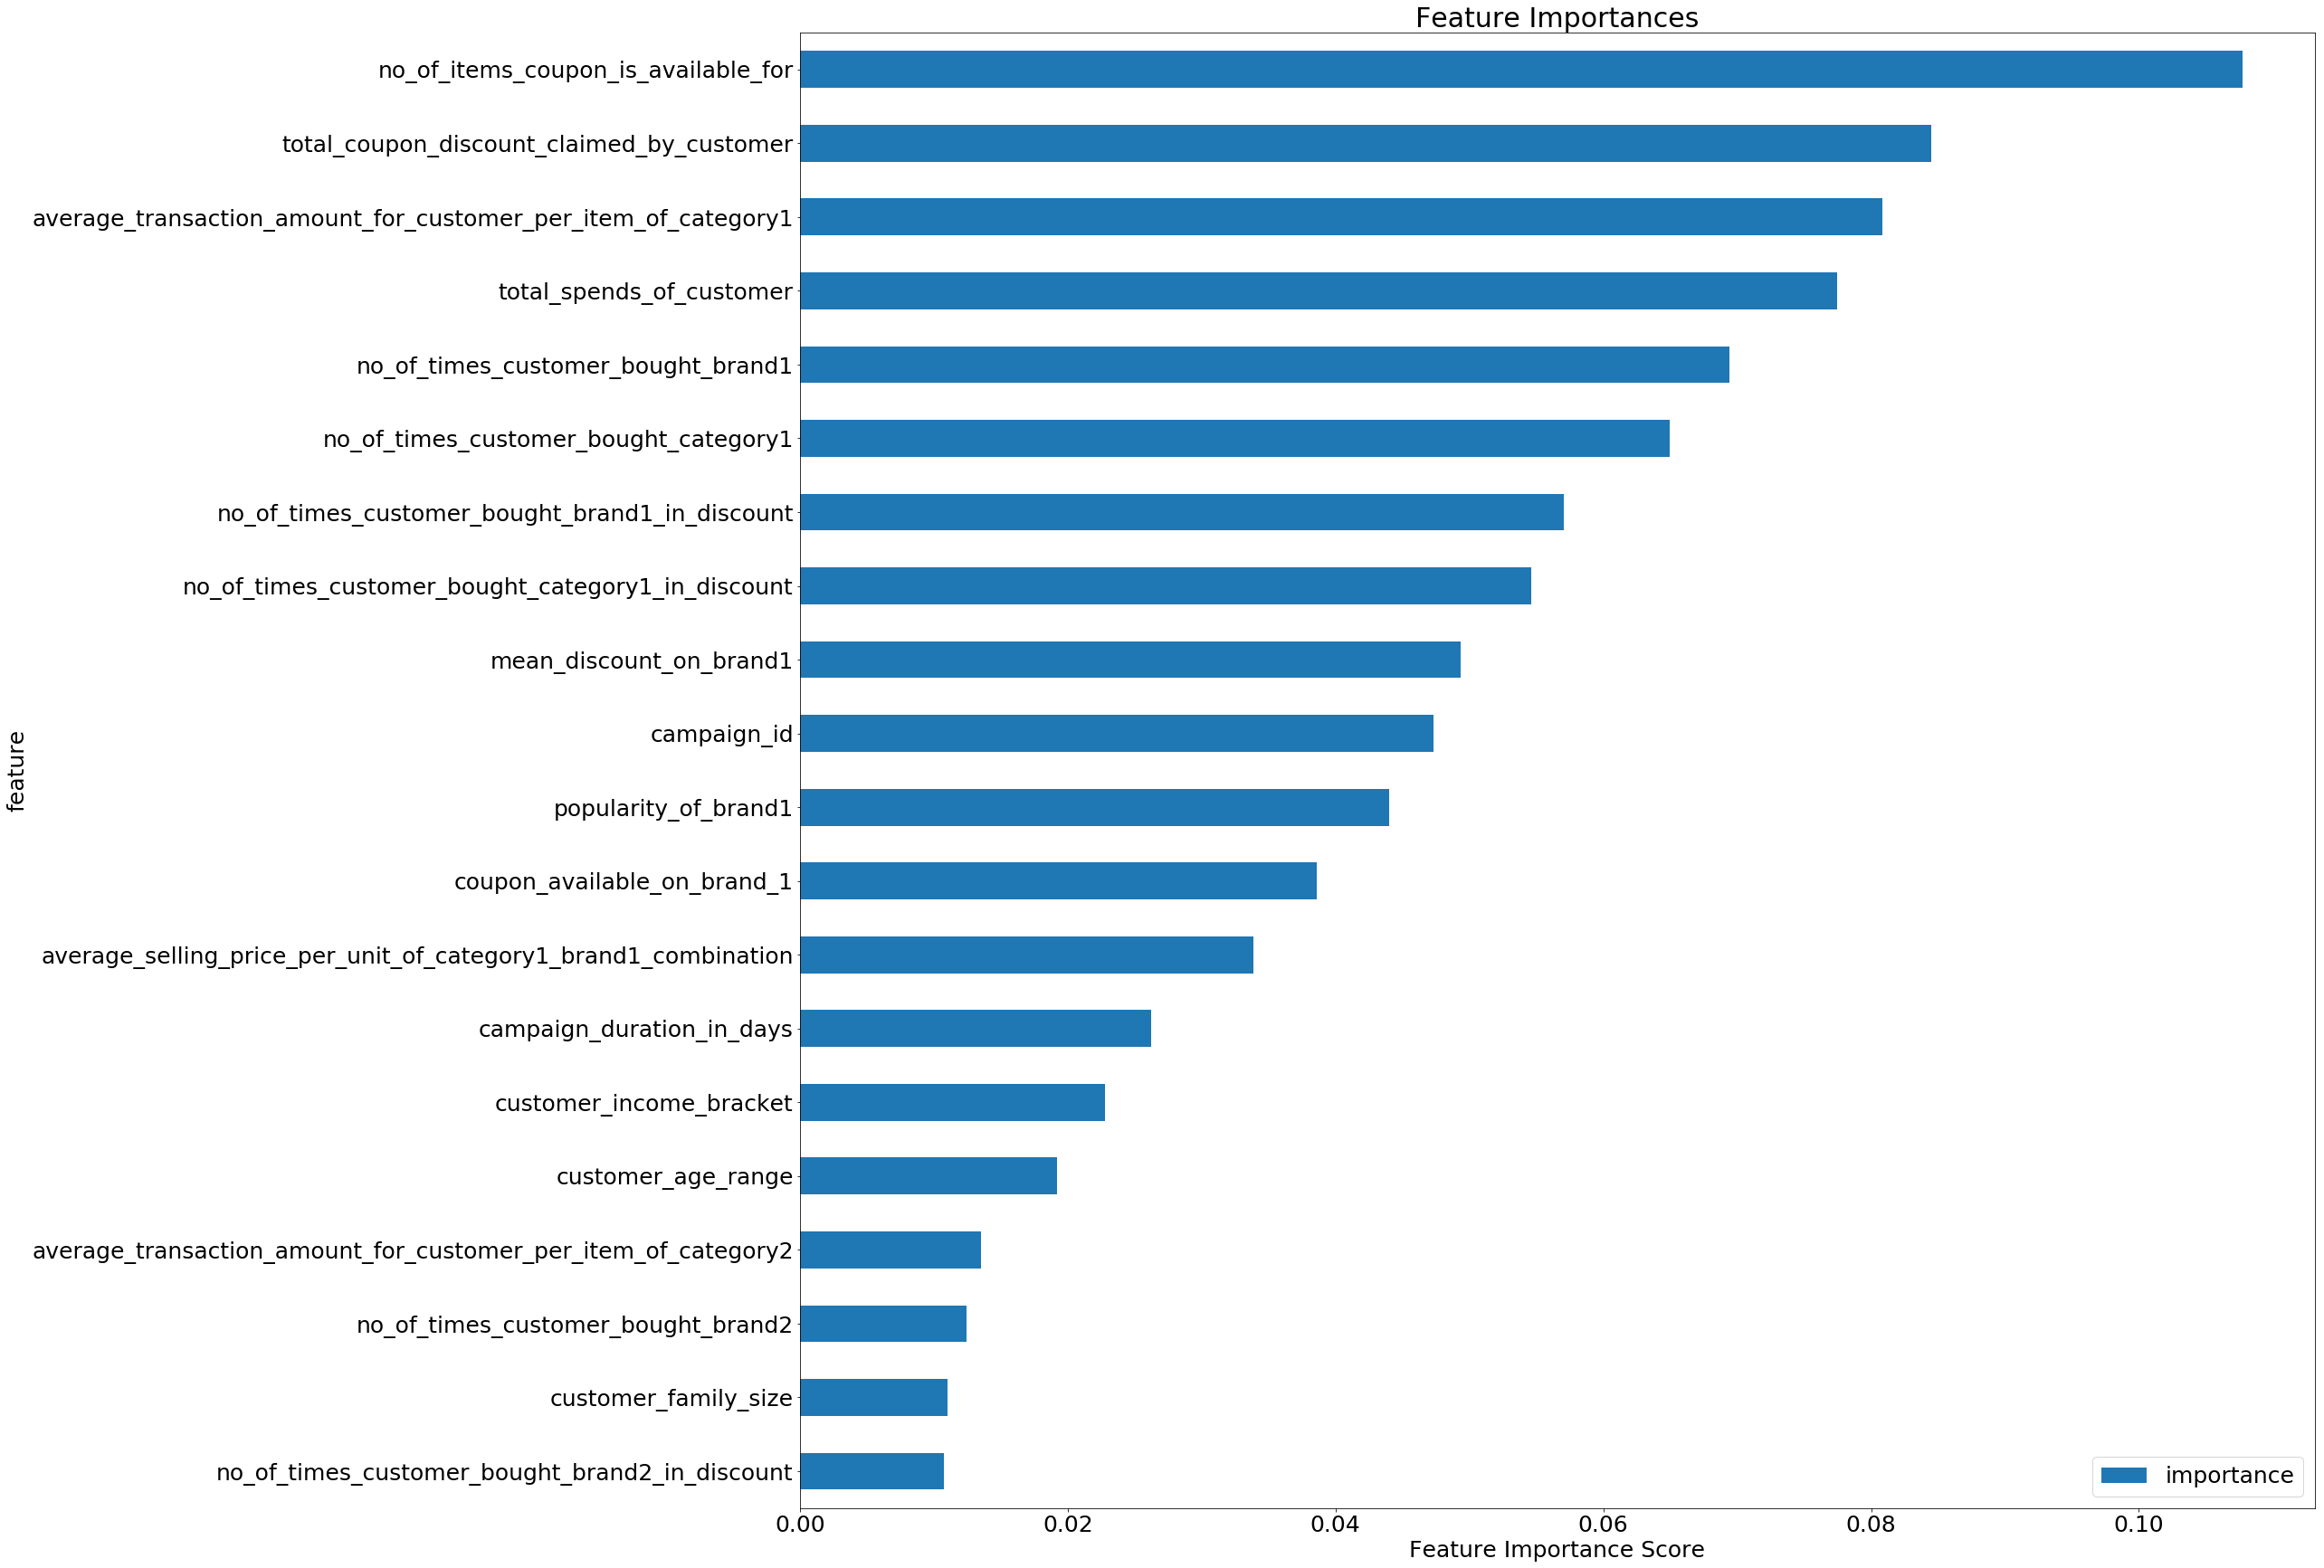

Top 20 features in descending order of importance


,importance
feature,
no_of_items_coupon_is_available_for,0.107746
total_coupon_discount_claimed_by_customer,0.084469
average_transaction_amount_for_customer_per_item_of_category1,0.080810
total_spends_of_customer,0.077462
no_of_times_customer_bought_brand1,0.069443
no_of_times_customer_bought_category1,0.064928
no_of_times_customer_bought_brand1_in_discount,0.057065
no_of_times_customer_bought_category1_in_discount,0.054652
mean_discount_on_brand1,0.049358


In [14]:
def plot_importance(clf, top_n, title="Feature Importances", figsize=(30,30) ):
    feat_imp = pd.DataFrame({'importance':clf.feature_importances_})    
    feat_imp['feature'] = train[features].columns
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp = feat_imp.iloc[:top_n]

    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(title=title, figsize=figsize)
    plt.xlabel('Feature Importance Score')
    plt.show()
    
    print("Top {} features in descending order of importance".format(top_n))
    display(feat_imp.sort_values(by='importance', ascending=False))
    
plot_importance(clf.best_estimator_, 20)

## Saving submissions

In [17]:
c='final'
test['redemption_status'] =clf.predict_proba(test[features])[:,1]
submission = test.loc[:,['id', 'redemption_status']]
name = "../data/submissions/submission_after_xgb_modeling_"+str(c)+".csv"
submission.to_csv( name,index=False)
print("File saved!")



File saved!


In [18]:
test['redemption_status']

0        4.930832e-02
1        1.216368e-05
2        1.059312e-06
3        2.008840e-11
4        1.397163e-08
             ...     
50221    1.127315e-06
50222    4.976914e-04
50223    9.088521e-05
50224    8.021926e-03
50225    6.408305e-09
Name: redemption_status, Length: 50226, dtype: float32

In [98]:
clf.predict_proba(test[features])[:,1]

array([4.6577238e-04, 1.2766468e-05, 1.6535791e-05, ..., 8.6532316e-05,
       9.8959003e-03, 7.1890334e-08], dtype=float32)